This notebook compares the scores of the local models and the model chain, uses MICE and tries to get insight into permutation feature importance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import itertools
#import random

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import r2_score, accuracy_score
from chaining_featimp import Chain
import os

In [2]:
def missingness_stratified_cv(df, N_FOLDS=5, random_state=None):
    # Add seed for reproducibility of the predictions (to get the same scores each time we run the code)
    np.random.seed(random_state)

    # Initial complete-case test fold assignment
    cv = pd.Series(np.nan, index=df.index)
    i_cc = (df.isna().sum(axis=1) == 0) # Complete cases
    cv.iloc[i_cc] = np.random.randint(low=0, high=N_FOLDS, size=i_cc.sum())

    # Go over columns from most missing to least missing
    for j in df.isna().sum().argsort()[::-1]:
        # Instances i that are not assigned yet but for which df[i,j] is observed
        i_tbf = (cv.isna()) & (~df.iloc[:,j].isna()) # to be filled
        # Fill them randomly
        cv.iloc[i_tbf] = np.random.randint(low=0, high=N_FOLDS, size=i_tbf.sum())

    return cv

In [3]:
possible_paths = [
    'C:/Users/lenne/OneDrive/Documenten/Master of Statistics and Data Science/2023-2024/Master thesis/Thesis_Sofia_Lennert/new_data',
    'C:/Users/anaso/Desktop/SOFIA MENDES/KU Leuven/Master Thesis/Thesis_Sofia_Lennert/new_data'
]

# Define file names
file = 'merged_data.csv'

# Find full paths to the CSV files
path = next((f'{path}/{file}' for path in possible_paths if os.path.exists(f'{path}/{file}')), None)

data = pd.read_csv(path)

# Bin the number of relapses into 0, 1, 2, 3 and 4+ 
def bin_column(value):
    if value in [0, 1, 2, 3]:
        return str(value)
    else:
        return '4+'
data['NRELAP'] = data['NRELAP'].apply(bin_column)

# Resulting DataFrame will have aggregated data from all four datasets based on the specific_column
pd.set_option('display.max_columns', None)
data

,USUBJID,AGE,SEX,RACE,CONTINENT,CESEV,CECONTRT,TOTRELAP,MHCONTRT,MHDIAGN,CARDIO,URINARY,MUSCKELET,FATIGUE,SMSTDY,NRELAP,NHPT-before,NHPT-2y,NHPT-after_2y,PASAT_2s-before,PASAT_2s-2y,PASAT_2s-after_2y,PASAT_3s-before,PASAT_3s-2y,PASAT_3s-after_2y,SDMT-before,SDMT-2y,T25FW-before,T25FW-2y,T25FW-after_2y,T-before,T-after,P-before,P-after,N-before,N-after,DS,DS_L,DS_R,SLEC_before,SLEC_after,SES_after,SES_before,VAA,BDI-before,BDI-after,EDSS-before,EDSS-2y,EDSS-after_2y,KFSS1-Sensory-2y,KFSS1-Sensory-after_2y,KFSS1-Sensory-before,KFSS1-Brain-2y,KFSS1-Brain-after_2y,KFSS1-Brain-before,KFSS1-Bowel-2y,KFSS1-Bowel-after_2y,KFSS1-Bowel-before,KFSS1-Pyramidal-2y,KFSS1-Pyramidal-after_2y,KFSS1-Pyramidal-before,KFSS1-Cerebral-2y,KFSS1-Cerebral-after_2y,KFSS1-Cerebral-before,KFSS1-Visual-2y,KFSS1-Visual-after_2y,KFSS1-Visual-before,KFSS1-Cerebellar-2y,KFSS1-Cerebellar-after_2y,KFSS1-Cerebellar-before,KFSS_M-2y,KFSS_M-after_2y,KFSS_M-before,KFSS_P-2y,KFSS_P-after_2y,KFSS_P-before,M_R36-SF12-before,P_R36-SF12-before,R36-SF12-before_Ind,M_R36-SF12-after,P_R36-SF12-after,R36-SF12-after_Ind
0,MSOAC/0014,46.0,F,NaN,NaN,NaN,NaN,NaN,NaN,RRMS,0,0,0,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MSOAC/0016,NaN,M,WHITE,NORTH AMERICA,NaN,NaN,NaN,Y,SPMS,1,1,0,1,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.55,6.60,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MSOAC/0019,44.0,M,NON-WHITE,NaN,NaN,NaN,NaN,NaN,PPMS,1,1,0,0,NaN,0.0,23.65,21.30,20.15,34.5,35.5,43.0,43.5,51.0,53.0,NaN,NaN,6.30,6.15,5.85,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.75,3.50,3.0,0.333333,0.166667,0.500000,0.2,0.0,0.2,0.000000,0.166667,0.083333,0.333333,0.5,0.416667,0.0,0.0,0.0,0.333333,0.0,0.333333,0.0,0.2,0.0,0.185185,0.185185,0.240741,0.166667,0.083333,0.208333,0.828571,0.772152,1.0,0.857143,0.721519,1.0
3,MSOAC/0024,60.0,M,WHITE,NORTH AMERICA,NaN,NaN,NaN,NaN,SPMS,1,1,1,1,NaN,0.0,34.45,37.50,NaN,55.0,54.0,NaN,60.0,60.0,NaN,NaN,NaN,4.50,5.25,NaN,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031746,0.023810,4.00,3.75,NaN,0.333333,NaN,0.333333,0.0,NaN,0.1,0.583333,NaN,0.666667,0.166667,NaN,0.250000,0.0,NaN,0.0,0.000000,NaN,0.083333,0.2,NaN,0.5,0.129630,NaN,0.240741,0.291667,NaN,0.375000,0.885714,0.569620,1.0,0.857143,0.716216,1.0
4,MSOAC/0030,28.0,F,WHITE,EUROPE,NaN,NaN,NaN,NaN,RRMS,1,1,0,1,NaN,0.0,16.55,17.90,NaN,NaN,NaN,NaN,58.0,60.0,NaN,63.5,69.0,4.85,4.70,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,26.0,24.0,1.25,1.25,NaN,0.063492,0.039683,2.00,1.50,NaN,0.166667,NaN,0.166667,0.2,NaN,0.2,0.166667,NaN,0.166667,0.166667,NaN,0.333333,0.0,NaN,0.2,0.166667,NaN,0.083333,0.0,NaN,0.1,0.111111,NaN,0.203704,0.166667,NaN,0.125000,0.933333,0.846154,0.0,0.833333,0.730769,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2460,MSOAC/9986,46.0,M,WHITE,OCEANIA,NaN,NaN,NaN,NaN,RRMS,1,1,0,1,NaN,0.0,19.35,18.95,NaN,NaN,NaN,NaN,58.0,60.0,NaN,51.0,60.0,3.90,3.80,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,36.0,35.0,1.25,1.25,NaN,0.047619,0.063492,2.75,2.50,NaN,0.333333,NaN,0.166667,0.0,NaN,0.0,0.333333,NaN,0.250000,0.166667,NaN,0.333333,0.0,NaN,0.0,0.000000,NaN,0.000000,0.0,NaN,0.2,0.111111,NaN,0.148148,0.166667,NaN,0.125000,0.833333,0.730769,0.0,0.800000,0.750000,0.0
2461,MSOAC/9987,18.0,F,NaN,NaN,NaN,NaN,NaN,NaN,RRMS,0,0,0,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [4]:
#variables = ['KFSS_M-2y', 'EDSS-2y', 'T25FW-2y', 'NRELAP']# removed KFSS_P-2y for now -- ('SMSTDY' gave a score of -0.03)
variables = ['KFSS_M-2y', 'KFSS_P-2y', 'EDSS-2y', 'T25FW-2y', 'NHPT-2y', 'P_R36-SF12-after', 'M_R36-SF12-after', 
             'SES_after', 'SLEC_after', 'EDSS-after_2y', 'KFSS_M-after_2y', 'KFSS_P-after_2y', 'NRELAP', 'CESEV']

Note: once we obtain the best ordering, change the order here!

In [5]:
# Extract targets
targets = data[variables]

# Extract features by dropping the target columns
#features = data.drop(variables, axis=1)

columns_to_keep = ['AGE', 'SEX', 'RACE', 'CONTINENT', 'MHDIAGN', 'CARDIO', 'URINARY', 'MUSCKELET', 'FATIGUE', 
                    'NHPT-before', 'PASAT_2s-before', 'PASAT_3s-before', 'SDMT-before', 'T25FW-before', 'SLEC_before','SES_before',
                    'BDI-before', 'EDSS-before', 'KFSS_M-before', 'KFSS_P-before', 'M_R36-SF12-before',
                	'P_R36-SF12-before', 'R36-SF12-before_Ind', 'T-before','P-before','N-before']
# still need to change in OE dataframe the SLEC and SES so name is consistent with the others

features = data[columns_to_keep]
features

,AGE,SEX,RACE,CONTINENT,MHDIAGN,CARDIO,URINARY,MUSCKELET,FATIGUE,NHPT-before,PASAT_2s-before,PASAT_3s-before,SDMT-before,T25FW-before,SLEC_before,SES_before,BDI-before,EDSS-before,KFSS_M-before,KFSS_P-before,M_R36-SF12-before,P_R36-SF12-before,R36-SF12-before_Ind,T-before,P-before,N-before
0,46.0,F,NaN,NaN,RRMS,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,M,WHITE,NORTH AMERICA,SPMS,1,1,0,1,NaN,NaN,NaN,NaN,8.55,NaN,NaN,NaN,6.00,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,44.0,M,NON-WHITE,NaN,PPMS,1,1,0,0,23.65,34.5,43.5,NaN,6.30,NaN,NaN,NaN,3.75,0.240741,0.208333,0.828571,0.772152,1.0,0.0,0.0,NaN
3,60.0,M,WHITE,NORTH AMERICA,SPMS,1,1,1,1,34.45,55.0,60.0,NaN,4.50,NaN,NaN,0.031746,4.00,0.240741,0.375000,0.885714,0.569620,1.0,0.0,0.0,1.0
4,28.0,F,WHITE,EUROPE,RRMS,1,1,0,1,16.55,NaN,58.0,63.5,4.85,26.0,1.25,0.063492,2.00,0.203704,0.125000,0.933333,0.846154,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2460,46.0,M,WHITE,OCEANIA,RRMS,1,1,0,1,19.35,NaN,58.0,51.0,3.90,36.0,1.25,0.047619,2.75,0.148148,0.125000,0.833333,0.730769,0.0,0.0,0.0,0.0
2461,18.0,F,NaN,NaN,RRMS,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2462,38.0,F,NaN,NaN,RRMS,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2463,40.0,F,WHITE,NaN,PPMS,0,1,0,1,23.80,21.5,31.5,NaN,6.15,NaN,NaN,NaN,4.50,0.481481,0.166667,0.728571,0.658228,1.0,0.0,0.0,NaN


In [6]:
object_columns = features.select_dtypes(include=['object'])
features = pd.get_dummies(features, columns=object_columns.columns, dtype=int)
features.head()

,AGE,CARDIO,URINARY,MUSCKELET,FATIGUE,NHPT-before,PASAT_2s-before,PASAT_3s-before,SDMT-before,T25FW-before,SLEC_before,SES_before,BDI-before,EDSS-before,KFSS_M-before,KFSS_P-before,M_R36-SF12-before,P_R36-SF12-before,R36-SF12-before_Ind,T-before,P-before,N-before,SEX_F,SEX_M,RACE_NON-WHITE,RACE_WHITE,CONTINENT_ASIA,CONTINENT_EURASIA,CONTINENT_EUROPE,CONTINENT_NORTH AMERICA,CONTINENT_OCEANIA,CONTINENT_SOUTH AMERICA,MHDIAGN_PPMS,MHDIAGN_RRMS,MHDIAGN_SPMS
0,46.0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,1,0
1,NaN,1,1,0,1,NaN,NaN,NaN,NaN,8.55,NaN,NaN,NaN,6.00,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,1,0,1,0,0,0,1,0,0,0,0,1
2,44.0,1,1,0,0,23.65,34.5,43.5,NaN,6.30,NaN,NaN,NaN,3.75,0.240741,0.208333,0.828571,0.772152,1.0,0.0,0.0,NaN,0,1,1,0,0,0,0,0,0,0,1,0,0
3,60.0,1,1,1,1,34.45,55.0,60.0,NaN,4.50,NaN,NaN,0.031746,4.00,0.240741,0.375000,0.885714,0.569620,1.0,0.0,0.0,1.0,0,1,0,1,0,0,0,1,0,0,0,0,1
4,28.0,1,1,0,1,16.55,NaN,58.0,63.5,4.85,26.0,1.25,0.063492,2.00,0.203704,0.125000,0.933333,0.846154,0.0,0.0,0.0,0.0,1,0,0,1,0,0,1,0,0,0,0,1,0


In [7]:
targets.dtypes

KFSS_M-2y           float64
KFSS_P-2y           float64
EDSS-2y             float64
T25FW-2y            float64
NHPT-2y             float64
P_R36-SF12-after    float64
M_R36-SF12-after    float64
SES_after           float64
EDSS-after_2y       float64
NRELAP               object
CESEV                object
dtype: object

Run MICE

In [8]:
featuresM=features.copy()

#missing_mask = featuresM.isna()
imputer = IterativeImputer(max_iter=10, random_state=42)
imputed_values = imputer.fit_transform(featuresM)

featuresM = pd.DataFrame(imputed_values, columns=featuresM.columns)
featuresM

c:\Users\lenne\anaconda3\envs\Thesis\lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,AGE,CARDIO,URINARY,MUSCKELET,FATIGUE,NHPT-before,PASAT_2s-before,PASAT_3s-before,SDMT-before,T25FW-before,SLEC_before,SES_before,BDI-before,EDSS-before,KFSS_M-before,KFSS_P-before,M_R36-SF12-before,P_R36-SF12-before,R36-SF12-before_Ind,T-before,P-before,N-before,SEX_F,SEX_M,RACE_NON-WHITE,RACE_WHITE,CONTINENT_ASIA,CONTINENT_EURASIA,CONTINENT_EUROPE,CONTINENT_NORTH AMERICA,CONTINENT_OCEANIA,CONTINENT_SOUTH AMERICA,MHDIAGN_PPMS,MHDIAGN_RRMS,MHDIAGN_SPMS
0,46.000000,0.0,0.0,0.0,0.0,25.018065,34.403347,43.574182,43.707050,10.321359,16.207326,0.953592,0.266973,3.302396,0.199786,0.111704,0.576803,0.636868,0.822802,0.013470,0.017288,0.019983,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,49.999556,1.0,1.0,0.0,1.0,32.248395,34.728405,45.174473,42.865450,8.550000,16.466525,0.994179,0.137418,6.000000,0.408692,0.302219,0.713367,0.593077,0.812958,0.000000,0.022124,0.030678,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,44.000000,1.0,1.0,0.0,0.0,23.650000,34.500000,43.500000,34.041493,6.300000,28.946702,0.992250,0.137595,3.750000,0.240741,0.208333,0.828571,0.772152,1.000000,0.000000,0.000000,0.016297,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,60.000000,1.0,1.0,1.0,1.0,34.450000,55.000000,60.000000,147.920671,4.500000,-79.622500,1.060940,0.031746,4.000000,0.240741,0.375000,0.885714,0.569620,1.000000,0.000000,0.000000,1.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,28.000000,1.0,1.0,0.0,1.0,16.550000,46.775832,58.000000,63.500000,4.850000,26.000000,1.250000,0.063492,2.000000,0.203704,0.125000,0.933333,0.846154,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2460,46.000000,1.0,1.0,0.0,1.0,19.350000,46.037596,58.000000,51.000000,3.900000,36.000000,1.250000,0.047619,2.750000,0.148148,0.125000,0.833333,0.730769,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2461,18.000000,0.0,0.0,0.0,0.0,24.024269,35.002518,44.138024,51.017268,10.424487,21.483848,1.003534,0.299753,3.036980,0.183260,0.104252,0.557752,0.669654,0.773500,0.005435,0.008969,0.007250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2462,38.000000,0.0,0.0,0.0,0.0,24.734123,34.574539,43.735280,45.795684,10.350824,17.714904,0.967861,0.276339,3.226563,0.195064,0.109575,0.571360,0.646235,0.808716,0.011174,0.014911,0.016345,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2463,40.000000,0.0,1.0,0.0,1.0,23.800000,21.500000,31.500000,14.910542,6.150000,49.104452,0.971514,0.248296,4.500000,0.481481,0.166667,0.728571,0.658228,1.000000,0.000000,0.000000,0.017645,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [9]:
selected_columns = featuresM.iloc[:, :-2]

# Compute the range for each column
ranges = selected_columns.apply(lambda x: x.max() - x.min())

print("Range of values for each column (except last two):")
print(ranges)

Range of values for each column (except last two):
AGE                         65.055452
CARDIO                       1.000000
URINARY                      1.000000
MUSCKELET                    1.000000
FATIGUE                      1.000000
NHPT-before                288.400000
PASAT_2s-before             67.470180
PASAT_3s-before             58.500000
SDMT-before                599.509092
T25FW-before               131.400000
SLEC_before                676.739216
SES_before                   1.195100
BDI-before                   0.856293
EDSS-before                  6.500000
KFSS_M-before                0.685185
KFSS_P-before                0.750000
M_R36-SF12-before            0.885714
P_R36-SF12-before            0.769231
R36-SF12-before_Ind          1.292154
T-before                     1.004456
P-before                     1.001466
N-before                     1.009040
SEX_F                        1.000000
SEX_M                        1.000000
RACE_NON-WHITE               1.000000

In [10]:
model_data = pd.concat([featuresM, targets], axis=1)
model_data

,AGE,CARDIO,URINARY,MUSCKELET,FATIGUE,NHPT-before,PASAT_2s-before,PASAT_3s-before,SDMT-before,T25FW-before,SLEC_before,SES_before,BDI-before,EDSS-before,KFSS_M-before,KFSS_P-before,M_R36-SF12-before,P_R36-SF12-before,R36-SF12-before_Ind,T-before,P-before,N-before,SEX_F,SEX_M,RACE_NON-WHITE,RACE_WHITE,CONTINENT_ASIA,CONTINENT_EURASIA,CONTINENT_EUROPE,CONTINENT_NORTH AMERICA,CONTINENT_OCEANIA,CONTINENT_SOUTH AMERICA,MHDIAGN_PPMS,MHDIAGN_RRMS,MHDIAGN_SPMS,KFSS_M-2y,KFSS_P-2y,EDSS-2y,T25FW-2y,NHPT-2y,P_R36-SF12-after,M_R36-SF12-after,SES_after,EDSS-after_2y,NRELAP,CESEV
0,46.000000,0.0,0.0,0.0,0.0,25.018065,34.403347,43.574182,43.707050,10.321359,16.207326,0.953592,0.266973,3.302396,0.199786,0.111704,0.576803,0.636868,0.822802,0.013470,0.017288,0.019983,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,49.999556,1.0,1.0,0.0,1.0,32.248395,34.728405,45.174473,42.865450,8.550000,16.466525,0.994179,0.137418,6.000000,0.408692,0.302219,0.713367,0.593077,0.812958,0.000000,0.022124,0.030678,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,6.60,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,44.000000,1.0,1.0,0.0,0.0,23.650000,34.500000,43.500000,34.041493,6.300000,28.946702,0.992250,0.137595,3.750000,0.240741,0.208333,0.828571,0.772152,1.000000,0.000000,0.000000,0.016297,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.185185,0.166667,3.50,6.15,21.30,0.721519,0.857143,NaN,3.0,0.0,NaN
3,60.000000,1.0,1.0,1.0,1.0,34.450000,55.000000,60.000000,147.920671,4.500000,-79.622500,1.060940,0.031746,4.000000,0.240741,0.375000,0.885714,0.569620,1.000000,0.000000,0.000000,1.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.129630,0.291667,3.75,5.25,37.50,0.716216,0.857143,NaN,NaN,0.0,NaN
4,28.000000,1.0,1.0,0.0,1.0,16.550000,46.775832,58.000000,63.500000,4.850000,26.000000,1.250000,0.063492,2.000000,0.203704,0.125000,0.933333,0.846154,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.111111,0.166667,1.50,4.70,17.90,0.730769,0.833333,1.25,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2460,46.000000,1.0,1.0,0.0,1.0,19.350000,46.037596,58.000000,51.000000,3.900000,36.000000,1.250000,0.047619,2.750000,0.148148,0.125000,0.833333,0.730769,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.111111,0.166667,2.50,3.80,18.95,0.750000,0.800000,1.25,NaN,0.0,NaN
2461,18.000000,0.0,0.0,0.0,0.0,24.024269,35.002518,44.138024,51.017268,10.424487,21.483848,1.003534,0.299753,3.036980,0.183260,0.104252,0.557752,0.669654,0.773500,0.005435,0.008969,0.007250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2462,38.000000,0.0,0.0,0.0,0.0,24.734123,34.574539,43.735280,45.795684,10.350824,17.714904,0.967861,0.276339,3.226563,0.195064,0.109575,0.571360,0.646235,0.808716,0.011174,0.014911,0.016345,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,MILD
2463,40.000000,0.0,1.0,0.0,1.0,23.800000,21.500000,31.500000,14.910542,6.150000,49.104452,0.971514,0.248296,4.500000,0.481481,0.166667,0.728571,0.658228,1.000000,0.000000,0.000000,0.017645,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.314815,0.166667,3.75,6.00,22.40,0.594937,0.757143,NaN,4.0,1.0,NaN


In [11]:
#missing_entries = model_data.isnull().any().any()

#if missing_entries:
#    print("DataFrame has missing entries.")
#else:
#    print("DataFrame does not have missing entries.")

In [12]:
#columns_to_encode = ['NRELAP', 'CESEV']

le1 = LabelEncoder()
le2 = LabelEncoder()

cesev = le1.fit_transform(np.array(model_data['CESEV']))
nrelap = le2.fit_transform(np.array(model_data['NRELAP']))

model_data['CESEV'] = cesev
model_data["CESEV"] = model_data["CESEV"].replace(3, np.nan)

model_data['NRELAP']=nrelap

# Impute missing values
imputer = IterativeImputer(max_iter=10, random_state=42)
imputed_values = imputer.fit_transform(model_data)

# Convert imputed values back to DataFrame
encoded_data = pd.DataFrame(imputed_values, columns=model_data.columns)

c:\Users\lenne\anaconda3\envs\Thesis\lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [13]:
#np.unique(encoded_data["CESEV"])

In [14]:
encoded_data[(encoded_data["CESEV"] <= -0.5) | (encoded_data["CESEV"] >= 2.5)]

,AGE,CARDIO,URINARY,MUSCKELET,FATIGUE,NHPT-before,PASAT_2s-before,PASAT_3s-before,SDMT-before,T25FW-before,SLEC_before,SES_before,BDI-before,EDSS-before,KFSS_M-before,KFSS_P-before,M_R36-SF12-before,P_R36-SF12-before,R36-SF12-before_Ind,T-before,P-before,N-before,SEX_F,SEX_M,RACE_NON-WHITE,RACE_WHITE,CONTINENT_ASIA,CONTINENT_EURASIA,CONTINENT_EUROPE,CONTINENT_NORTH AMERICA,CONTINENT_OCEANIA,CONTINENT_SOUTH AMERICA,MHDIAGN_PPMS,MHDIAGN_RRMS,MHDIAGN_SPMS,KFSS_M-2y,KFSS_P-2y,EDSS-2y,T25FW-2y,NHPT-2y,P_R36-SF12-after,M_R36-SF12-after,SES_after,EDSS-after_2y,NRELAP,CESEV
186,42.0,1.0,1.0,1.0,1.0,58.35,5.500000,8.0,49.205036,38.15,-17.685917,0.762270,0.317460,6.50,0.500000,0.291667,0.500000,0.430380,1.0,0.000000,0.000000,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.481481,0.333333,6.50,107.000000,69.50,0.696203,0.592857,0.600825,6.017046,0.0,-0.733289
773,62.0,1.0,1.0,1.0,1.0,29.05,46.000000,55.5,71.842759,5.65,-6.036754,0.920196,0.214805,4.00,0.277778,0.291667,0.685714,0.620253,1.0,0.000000,0.000000,0.033332,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.314815,0.416667,4.00,6.450000,37.50,0.493671,0.571429,0.794951,8.000000,0.0,2.786417
815,36.0,0.0,1.0,0.0,1.0,25.15,8.127879,11.0,11.500000,26.05,9.000000,0.625000,0.126984,2.00,0.111111,0.083333,0.866667,0.653846,0.0,0.000000,0.000000,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.111111,0.000000,3.00,107.000000,28.00,0.557692,0.666667,0.625000,3.157084,0.0,-0.566917
820,52.0,0.0,1.0,1.0,0.0,30.60,35.000000,53.5,-49.845305,3.95,132.799001,0.974824,0.082366,3.00,0.185185,0.166667,0.885714,0.898734,1.0,0.000000,0.000000,0.030559,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.166667,0.166667,3.00,4.700000,26.80,0.822785,0.871429,1.146600,2.000000,0.0,-0.713893
1180,38.0,0.0,1.0,1.0,1.0,70.55,45.048551,59.0,52.428959,26.85,18.668681,0.830895,0.209432,6.50,0.433379,0.283666,0.742857,0.531646,1.0,0.000000,0.000000,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.523216,0.450414,8.00,90.237789,300.00,0.424051,0.578571,0.840208,8.500000,0.0,-3.800055
1386,42.0,0.0,0.0,1.0,0.0,19.70,44.581606,54.5,50.518467,4.25,15.000000,1.000000,0.064296,1.50,0.037037,0.083333,0.871429,0.620253,1.0,0.011009,0.009932,0.007848,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.083333,1.00,4.250000,18.45,0.696203,0.635714,1.250000,0.500000,0.0,-0.508784
1426,43.0,0.0,0.0,1.0,0.0,24.20,37.000000,52.0,-5.982738,8.40,75.663713,0.835592,0.251815,6.00,0.408249,0.250000,0.614286,0.620253,1.0,0.000000,0.000000,0.018694,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.296296,0.166667,6.00,9.400000,25.15,0.569620,0.535714,0.965125,4.000000,0.0,-0.947022
1727,59.0,0.0,1.0,0.0,0.0,33.20,46.500000,56.0,73.717854,24.00,-21.002228,0.814010,0.178611,6.50,0.384844,0.273286,0.742857,0.632911,1.0,0.000000,0.000000,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.321138,0.272699,6.50,134.500000,30.50,0.556962,0.678571,0.572940,6.255409,0.0,-1.507409
1852,50.0,0.0,0.0,0.0,0.0,18.40,43.896815,55.5,51.032290,7.30,29.000000,1.250000,0.084656,3.00,0.148148,0.083333,0.828571,0.759494,1.0,0.016086,0.009566,0.020974,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.166667,0.083333,3.00,6.900000,17.80,0.702532,0.821429,1.250000,6.000000,0.0,2.618549
1891,49.0,1.0,1.0,0.0,1.0,35.20,38.500000,48.0,65.686350,11.40,2.041638,1.045090,0.080870,5.50,0.277778,0.000000,0.928571,0.734177,1.0,0.000000,0.000000,0.038188,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.259259,0.083333,7.25,134.700000,105.90,0.632911,0.785714,0.796956,8.500000,0.0,-1.412864


In [15]:
#ind = encoded_data[encoded_data["CESEV"] < -0.5].index
#model_data.loc[ind]

In [16]:
#missing_entries = encoded_data.isnull().any().any()

#if missing_entries:
#    print("DataFrame has missing entries.")
#else:
#    print("DataFrame does not have missing entries.")

In [17]:
#model_data['CESEV']

In [18]:
encoded_data.loc[encoded_data['CESEV'] < -0.5, 'CESEV'] = 0

cesev = np.array(encoded_data['CESEV']).round().astype(int)
nrelap = np.array(encoded_data['NRELAP']).round().astype(int)

In [19]:
print(np.unique(cesev))
print(np.count_nonzero(cesev == -2147483648))
print(np.count_nonzero(cesev == 3))

[0 1 2 3]
0
2


In [20]:
def replace_negative(arr):
    return np.where(arr == -2147483648, 0, arr)

def replace_three(arr):
    return np.where(arr == 3, 2, arr)

cesev = replace_negative(cesev)
cesev = replace_three(cesev)


print(np.unique(cesev))
print(np.count_nonzero(cesev == -2147483648))
print(np.count_nonzero(cesev == 3))

[0 1 2]
0
0


In [21]:
encoded_data['CESEV'] = le1.inverse_transform(cesev)
encoded_data['NRELAP'] = le2.inverse_transform(nrelap)

#print(encoded_data['CESEV'])
#print(encoded_data['NRELAP'])

In [22]:
encoded_data['CESEV'].unique()

array(['MODERATE', 'MILD', 'SEVERE'], dtype=object)

In [23]:
#np.unique(cesev)

In [24]:
targetsM = encoded_data[targets.columns]
targetsM

,KFSS_M-2y,KFSS_P-2y,EDSS-2y,T25FW-2y,NHPT-2y,P_R36-SF12-after,M_R36-SF12-after,SES_after,EDSS-after_2y,NRELAP,CESEV
0,0.232407,0.124376,3.582295,9.983181,23.982986,0.644123,0.628669,0.936889,3.784406,0.0,MODERATE
1,0.381770,0.279884,5.820997,6.600000,31.549511,0.598844,0.714682,0.998351,5.873150,0.0,MODERATE
2,0.185185,0.166667,3.500000,6.150000,21.300000,0.721519,0.857143,1.068035,3.000000,0.0,MILD
3,0.129630,0.291667,3.750000,5.250000,37.500000,0.716216,0.857143,1.098294,3.962655,0.0,MILD
4,0.111111,0.166667,1.500000,4.700000,17.900000,0.730769,0.833333,1.250000,1.754851,0.0,MODERATE
...,...,...,...,...,...,...,...,...,...,...,...
2460,0.111111,0.166667,2.500000,3.800000,18.950000,0.750000,0.800000,1.250000,2.636451,0.0,MILD
2461,0.217371,0.114939,3.286375,11.739348,24.504363,0.686292,0.625176,0.967693,3.238952,0.0,MODERATE
2462,0.249786,0.130484,3.607639,16.799483,29.725821,0.669465,0.619455,0.971766,3.296053,2.0,MILD
2463,0.314815,0.166667,3.750000,6.000000,22.400000,0.594937,0.757143,1.013271,4.000000,1.0,MODERATE


In [25]:
selected_columns = targetsM.iloc[:, :-2]

# Compute the range for each column
ranges = selected_columns.apply(lambda x: x.max() - x.min())

print("Range of values for each column (except last two):")
print(ranges)

Range of values for each column (except last two):
KFSS_M-2y             0.759259
KFSS_P-2y             0.752007
EDSS-2y               8.000000
T25FW-2y            177.200000
NHPT-2y             289.100000
P_R36-SF12-after      0.750000
M_R36-SF12-after      1.000000
SES_after             1.256768
EDSS-after_2y        11.794632
dtype: float64


5-Fold CV

In [26]:
# Set random state for reproducibility
random_state = 42
N_FOLDS = 5

In [27]:
# Generate CV folds
cv=missingness_stratified_cv(features, N_FOLDS, random_state)
cv = cv.to_frame(name="CV Fold")

featuresM_cv = pd.merge(featuresM, pd.DataFrame(cv), left_index=True, right_index=True)
targetsM_cv = pd.merge(targetsM, pd.DataFrame(cv), left_index=True, right_index=True)
targets_cv = pd.merge(targets, pd.DataFrame(cv), left_index=True, right_index=True)

featuresM_cv['CV Fold'].value_counts()

CV Fold
4.0    510
3.0    502
0.0    500
1.0    495
2.0    458
Name: count, dtype: int64

In [28]:
targetsM_cv.shape

(2465, 12)

In [29]:
targets_cv.shape

(2465, 12)

Is it a problem that not all folds have the exact same number?

---

# Local Models

In [30]:
y_pred_list = []
y_test_list = []
feat_imp_list = []

for i in range(0, N_FOLDS): 
    Xi_train = featuresM_cv[featuresM_cv['CV Fold'] != i].drop(["CV Fold"], axis=1)
    Xi_test = featuresM_cv[featuresM_cv['CV Fold'] == i].drop(["CV Fold"], axis=1)
    yi_train = targetsM_cv[targetsM_cv['CV Fold'] != i].drop(["CV Fold"], axis=1)
    yi_test = targets_cv[targets_cv['CV Fold'] == i].drop(["CV Fold"], axis=1)
    y_test_list.append(pd.DataFrame(yi_test, columns=yi_test.columns, index=yi_test.index))

    chain = Chain(
        model_reg=RandomForestRegressor(random_state=random_state),
        model_clf=RandomForestClassifier(random_state=random_state),
        propagate=False, #RUN LOCAL MODELS
    )
    chain.fit(Xi_train, yi_train, target_types=None) #["reg","reg","reg","reg","reg","reg","reg","reg","reg","clf","clf"]
    output = chain.predict(Xi_test, yi_test)
    y_pred = output[0]
    y_pred_list.append(pd.DataFrame(y_pred, columns=yi_test.columns, index=yi_test.index))
    feat_imp = output[1]
    feat_imp_list.append(feat_imp)
    print("Done with evaluating on CV Fold {}".format(i+1))

Done with evaluating on CV Fold 1
Done with evaluating on CV Fold 2
Done with evaluating on CV Fold 3
Done with evaluating on CV Fold 4
Done with evaluating on CV Fold 5


feat_imp_list[fold][outcome]

In [68]:
print(len(feat_imp_list), len(feat_imp_list[0]))
print(feat_imp_list[0][10])
print("\n")
print("feat_imp_list contains 5 folds x 11 models x 35 features")

5 11
[0.038  0.0306 0.0108 0.0082 0.0208 0.0318 0.0448 0.0316 0.0398 0.091
 0.033  0.0374 0.035  0.0476 0.0444 0.0686 0.0468 0.063  0.044  0.0238
 0.026  0.0292 0.0166 0.0086 0.0012 0.007  0.0004 0.0004 0.017  0.0086
 0.     0.0002 0.0046 0.0098 0.0104]


feat_imp_list contains 5 folds x 11 models x 35 features


In [57]:
# Convert the list to a numpy array for easier manipulation
feat_imp_array = np.array(feat_imp_list)

# Calculate the mean importance across all folds for each feature
mean_imp_across_folds = np.mean(feat_imp_array, axis=0)
print(len(mean_imp_across_folds), len(mean_imp_across_folds[0]))

# Calculate the standard errors of importance across folds for each feature
std_imp_across_folds = np.std(feat_imp_array, axis=0)

11 35


mean_imp_across_folds[outcome][input variable]

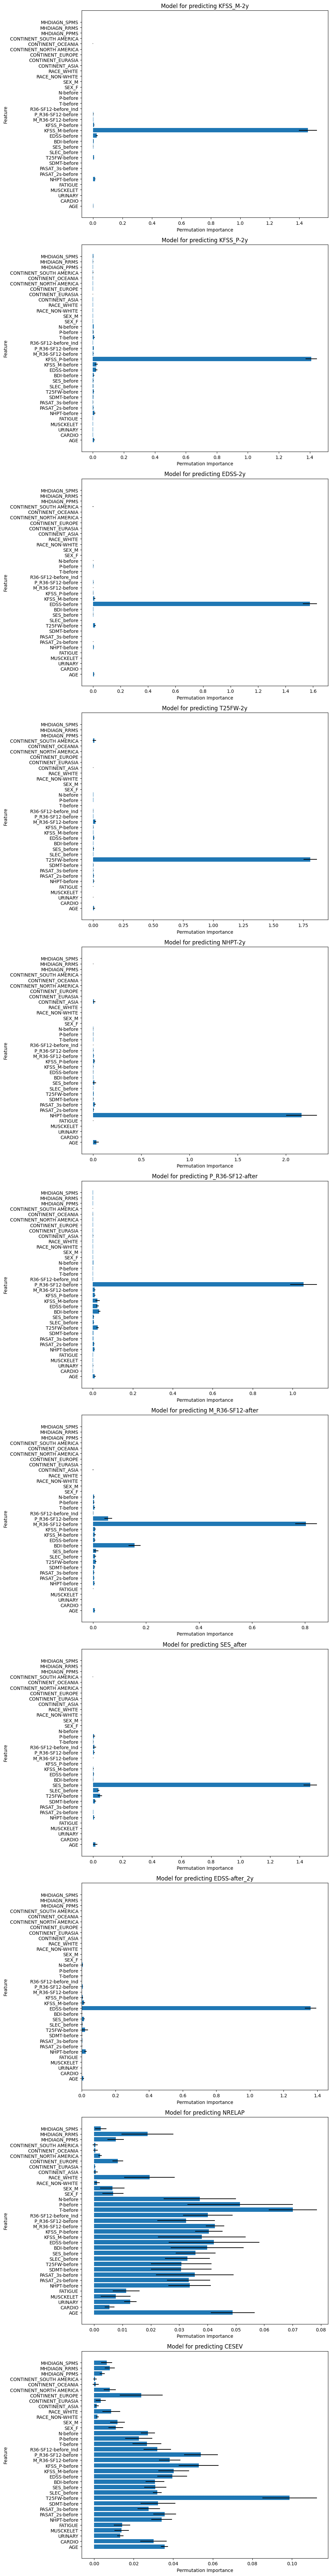

In [70]:
# Extract feature names
feature_names = features.columns

# Create subplots for each model
num_models = mean_imp_across_folds.shape[0]
fig, axs = plt.subplots(num_models, figsize=(10, 7*num_models), sharex=False)

# Plot permutation-based importance for each model
for i in range(num_models):
    axs[i].barh(feature_names, mean_imp_across_folds[i], xerr=std_imp_across_folds[i]) 
    axs[i].set_title("Model for predicting {}".format(variables[i]))  # Insert outcome into title
    axs[i].set_xlabel('Permutation Importance')
    axs[i].set_ylabel('Feature')

# Adjust layout and display plot
plt.tight_layout()
plt.show()

In [31]:
result=feat_imp_list[0][0]

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

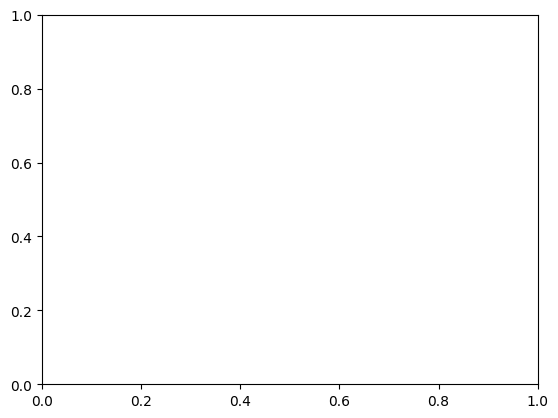

In [32]:
fig, ax = plt.subplots()
result.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")

In [32]:
#y_pred_list

In [33]:
y_test_cv = []
y_pred_cv = []

for j in range(len(y_test_list)):  # 5
    y_test_targ = []
    y_pred_targ = []
    nvar=y_test_list[0].shape[1]

    for i in range(0, nvar):  # or (1, 5)
        missing_rows_mask = y_test_list[j].iloc[:, i].isna()
        y_test = y_test_list[j].iloc[:, i][~missing_rows_mask]
        y_pred = y_pred_list[j].iloc[:, i][~missing_rows_mask]
        
        y_test_targ.append(y_test)
        y_pred_targ.append(y_pred)
    
    y_test_cv.append(y_test_targ)
    y_pred_cv.append(y_pred_targ)
# y_test_cv[fold][outcome]

1st index: fold, 2nd index: outcome

In [34]:
# Initialize a list to store scores
scores = []
scores_with_std = []

# Iterate over each outcome variable in the folds
for variable_name in variables: #CHANGE VAR LIST HERE
    variable_scores = []
    
    # Compute scores for the variable across all folds
    for fold_index in range(len(y_test_cv)):
        y_test = y_test_cv[fold_index][variables.index(variable_name)] #CHANGE VAR LIST HERE
        y_pred = y_pred_cv[fold_index][variables.index(variable_name)] #CHANGE VAR LIST HERE
        
        # Check if the target variable is numerical or categorical
        if y_test.dtype.kind in 'bifc':
            score = r2_score(y_test, y_pred)
        else:
            score = accuracy_score(y_test, y_pred)
                  
        variable_scores.append(score)
    
    # Compute the average score for the variable across all folds
    variable_avg_score = np.mean(variable_scores)
    # Compute the standard deviation for the variable across all folds
    variable_std_score = np.std(variable_scores)
    scores_with_std.append((variable_name, variable_avg_score, variable_std_score))

# Print the scores with average and standard deviation along with variable names
print("Scores for each outcome (local):")
for variable_name, avg_score, std_score in scores_with_std:
    print(f"{variable_name}: {avg_score:.2f} (± {std_score:.2f})")

Scores for each outcome (local):
KFSS_M-2y: 0.80 (± 0.03)
KFSS_P-2y: 0.75 (± 0.03)
EDSS-2y: 0.88 (± 0.01)
T25FW-2y: 0.71 (± 0.08)
NHPT-2y: 0.56 (± 0.17)
P_R36-SF12-after: 0.68 (± 0.05)
M_R36-SF12-after: 0.55 (± 0.03)
SES_after: 0.70 (± 0.05)
EDSS-after_2y: 0.75 (± 0.04)
NRELAP: 0.63 (± 0.02)
CESEV: 0.51 (± 0.03)


*Questions/Notes*: 
- using pred="true" gives always score 1 (weird)

---

# Model Chain

### Propagate predicted values

In [31]:
y_pred_list = []
y_test_list = []
feat_imp_list = []

for i in range(0, N_FOLDS): 
    Xi_train = featuresM_cv[featuresM_cv['CV Fold'] != i].drop(["CV Fold"], axis=1)
    Xi_test = featuresM_cv[featuresM_cv['CV Fold'] == i].drop(["CV Fold"], axis=1)
    yi_train = targetsM_cv[targetsM_cv['CV Fold'] != i].drop(["CV Fold"], axis=1)
    yi_test = targets_cv[targets_cv['CV Fold'] == i].drop(["CV Fold"], axis=1)
    y_test_list.append(pd.DataFrame(yi_test, columns=yi_test.columns, index=yi_test.index))

    chain = Chain(
        model_reg=RandomForestRegressor(random_state=random_state),
        model_clf=RandomForestClassifier(random_state=random_state),
        propagate="pred", #RUN MODELS IN A CHAIN
    )
    chain.fit(Xi_train, yi_train, target_types=None) #["reg","reg","reg","reg","reg","reg","reg","reg","reg","clf","clf"]
    output = chain.predict(Xi_test)
    y_pred = output[0]
    y_pred_list.append(pd.DataFrame(y_pred, columns=yi_test.columns, index=yi_test.index))
    feat_imp = output[1]
    feat_imp_list.append(feat_imp)
    print("Done with evaluating on CV Fold {}".format(i+1))

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [35]:
y_test_cv = []
y_pred_cv = []

for j in range(len(y_test_list)):  # 5
    y_test_targ = []
    y_pred_targ = []
    nvar=y_test_list[0].shape[1]

    for i in range(0, nvar):  # or (1, 5)
        missing_rows_mask = y_test_list[j].iloc[:, i].isna()
        y_test = y_test_list[j].iloc[:, i][~missing_rows_mask]
        y_pred = y_pred_list[j].iloc[:, i][~missing_rows_mask]
        
        y_test_targ.append(y_test)
        y_pred_targ.append(y_pred)
    
    y_test_cv.append(y_test_targ)
    y_pred_cv.append(y_pred_targ)
# y_test_cv[fold][outcome]

In [36]:
# Initialize a list to store scores
scores = []
scores_with_std = []

# Iterate over each outcome variable in the folds
for variable_name in variables: 
    variable_scores = []
    
    # Compute scores for the variable across all folds
    for fold_index in range(len(y_test_cv)):
        y_test = y_test_cv[fold_index][variables.index(variable_name)] 
        y_pred = y_pred_cv[fold_index][variables.index(variable_name)] 
        
        # Check if the target variable is numerical or categorical
        if y_test.dtype.kind in 'bifc':
            score = r2_score(y_test, y_pred)
        else:
            score = accuracy_score(y_test, y_pred)
                  
        variable_scores.append(score)
    
    # Compute the average score for the variable across all folds
    variable_avg_score = np.mean(variable_scores)
    # Compute the standard deviation for the variable across all folds
    variable_std_score = np.std(variable_scores)
    scores_with_std.append((variable_name, variable_avg_score, variable_std_score))

# Print the scores with average and standard deviation along with variable names
print("Scores for each outcome (chain - predicted values):")
for variable_name, avg_score, std_score in scores_with_std:
    print(f"{variable_name}: {avg_score:.2f} (± {std_score:.2f})")

Scores for each outcome (chain - predicted values):
KFSS_M-2y: 0.81 (± 0.03)
KFSS_P-2y: 0.75 (± 0.02)
EDSS-2y: 0.88 (± 0.02)
T25FW-2y: 0.72 (± 0.07)
NHPT-2y: 0.58 (± 0.19)
P_R36-SF12-after: 0.69 (± 0.05)
M_R36-SF12-after: 0.55 (± 0.02)
SES_after: 0.70 (± 0.05)
EDSS-after_2y: 0.74 (± 0.05)
NRELAP: 0.64 (± 0.02)
CESEV: 0.52 (± 0.02)


### Propagate true values

Still need to fix clf in chaining.py for propagate="true" -- do not run the code below, it won't work

In [37]:
y_pred_list = []
y_test_list = []

for i in range(0, N_FOLDS): 
    Xi_train = featuresM_cv[featuresM_cv['CV Fold'] != i].drop(["CV Fold"], axis=1)
    Xi_test = featuresM_cv[featuresM_cv['CV Fold'] == i].drop(["CV Fold"], axis=1)
    yi_train = targetsM_cv[targetsM_cv['CV Fold'] != i].drop(["CV Fold"], axis=1)
    yi_test = targets_cv[targets_cv['CV Fold'] == i].drop(["CV Fold"], axis=1)
    y_test_list.append(pd.DataFrame(yi_test, columns=yi_test.columns, index=yi_test.index))

    chain = Chain(
        model_reg=RandomForestRegressor(random_state=random_state),
        model_clf=RandomForestClassifier(random_state=random_state),
        propagate="true", #RUN MODELS IN A CHAIN
    )
    chain.fit(Xi_train, yi_train, target_types=None) #["reg","reg","reg","reg","reg","reg","reg","reg","reg","clf","clf"]
    y_pred = chain.predict(Xi_test)
    y_pred_list.append(pd.DataFrame(y_pred, columns=yi_test.columns, index=yi_test.index))
    print("Done with evaluating on CV Fold {}".format(i+1))

Done with evaluating on CV Fold 1
Done with evaluating on CV Fold 2
Done with evaluating on CV Fold 3
Done with evaluating on CV Fold 4
Done with evaluating on CV Fold 5


In [38]:
y_test_cv = []
y_pred_cv = []

for j in range(len(y_test_list)):  # 5
    y_test_targ = []
    y_pred_targ = []
    nvar=y_test_list[0].shape[1]

    for i in range(0, nvar):  # or (1, 5)
        missing_rows_mask = y_test_list[j].iloc[:, i].isna()
        y_test = y_test_list[j].iloc[:, i][~missing_rows_mask]
        y_pred = y_pred_list[j].iloc[:, i][~missing_rows_mask]
        
        y_test_targ.append(y_test)
        y_pred_targ.append(y_pred)
    
    y_test_cv.append(y_test_targ)
    y_pred_cv.append(y_pred_targ)
# y_test_cv[fold][outcome]

In [39]:
# Initialize a list to store scores
scores = []
scores_with_std = []

# Iterate over each outcome variable in the folds
for variable_name in variables: 
    variable_scores = []
    
    # Compute scores for the variable across all folds
    for fold_index in range(len(y_test_cv)):
        y_test = y_test_cv[fold_index][variables.index(variable_name)] 
        y_pred = y_pred_cv[fold_index][variables.index(variable_name)] 
        
        # Check if the target variable is numerical or categorical
        if y_test.dtype.kind in 'bifc':
            score = r2_score(y_test, y_pred)
        else:
            score = accuracy_score(y_test, y_pred)
                  
        variable_scores.append(score)
    
    # Compute the average score for the variable across all folds
    variable_avg_score = np.mean(variable_scores)
    # Compute the standard deviation for the variable across all folds
    variable_std_score = np.std(variable_scores)
    scores_with_std.append((variable_name, variable_avg_score, variable_std_score))

# Print the scores with average and standard deviation along with variable names
print("Scores for each outcome (chain - true values):")
for variable_name, avg_score, std_score in scores_with_std:
    print(f"{variable_name}: {avg_score:.2f} (± {std_score:.2f})")

Scores for each outcome (chain - true values):
KFSS_M-2y: 0.81 (± 0.03)
KFSS_P-2y: 0.75 (± 0.03)
EDSS-2y: 0.88 (± 0.01)
T25FW-2y: 0.73 (± 0.07)
NHPT-2y: 0.59 (± 0.19)
P_R36-SF12-after: 0.68 (± 0.05)
M_R36-SF12-after: 0.55 (± 0.02)
SES_after: 0.70 (± 0.05)
EDSS-after_2y: 0.74 (± 0.04)
NRELAP: 0.61 (± 0.02)
CESEV: 0.50 (± 0.02)
